<a href="https://colab.research.google.com/github/zahidparviz/waste_classificatio_enhanced/blob/main/WasteClassifier2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# Part 1: Importing necessary libraries and specifying the dataset path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from collections import Counter
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from glob import glob
import warnings
warnings.filterwarnings('ignore')
import os

In [32]:
# Part 2: Importing additional useful libraries.

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.utils import plot_model
from glob import glob
import os

# Path to the extracted DATASET directory
extracted_path = '/content/DATASET/'

# Update the paths
train_path = os.path.join(extracted_path, 'TRAIN')
test_path = os.path.join(extracted_path, 'TEST')

# Display the updated paths
print(f"Updated train_path: {train_path}")
print(f"Updated test_path: {test_path}")


Updated train_path: /content/DATASET/TRAIN
Updated test_path: /content/DATASET/TEST


In [31]:
import zipfile
import os

# Define the path to the zip file
zip_file_path = "/content/DATASET.zip"

# Open the zip file
with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    # Extract the contents of the zip file to the same directory
    zip_ref.extractall(os.path.dirname(zip_file_path))


In [33]:
# Part 3: Loading and preprocessing the dataset
x_data = []
y_data = []

for category in glob(train_path + '/*'):
    for file in tqdm(glob(category + '/*')):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

data = pd.DataFrame({'image': x_data, 'label': y_data})


100%|██████████| 12565/12565 [00:12<00:00, 1046.75it/s]


100%|██████████| 12565/12565 [00:10<00:00, 1176.87it/s]


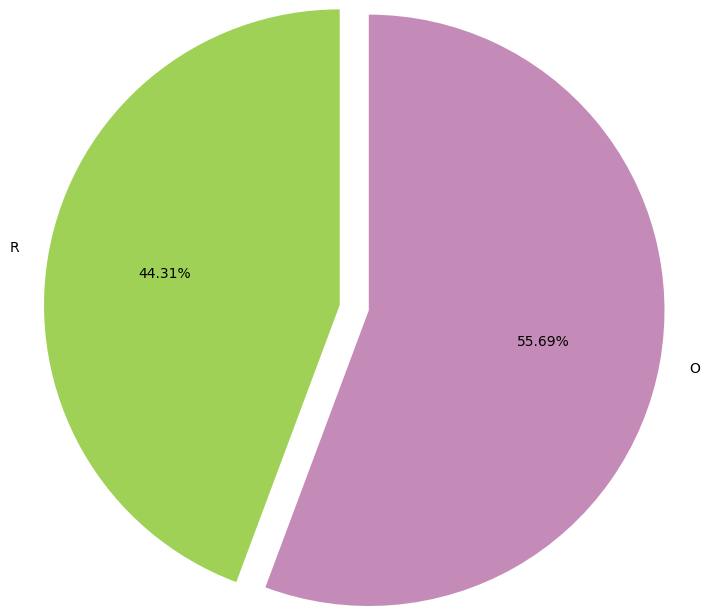

Number Of Class:  2


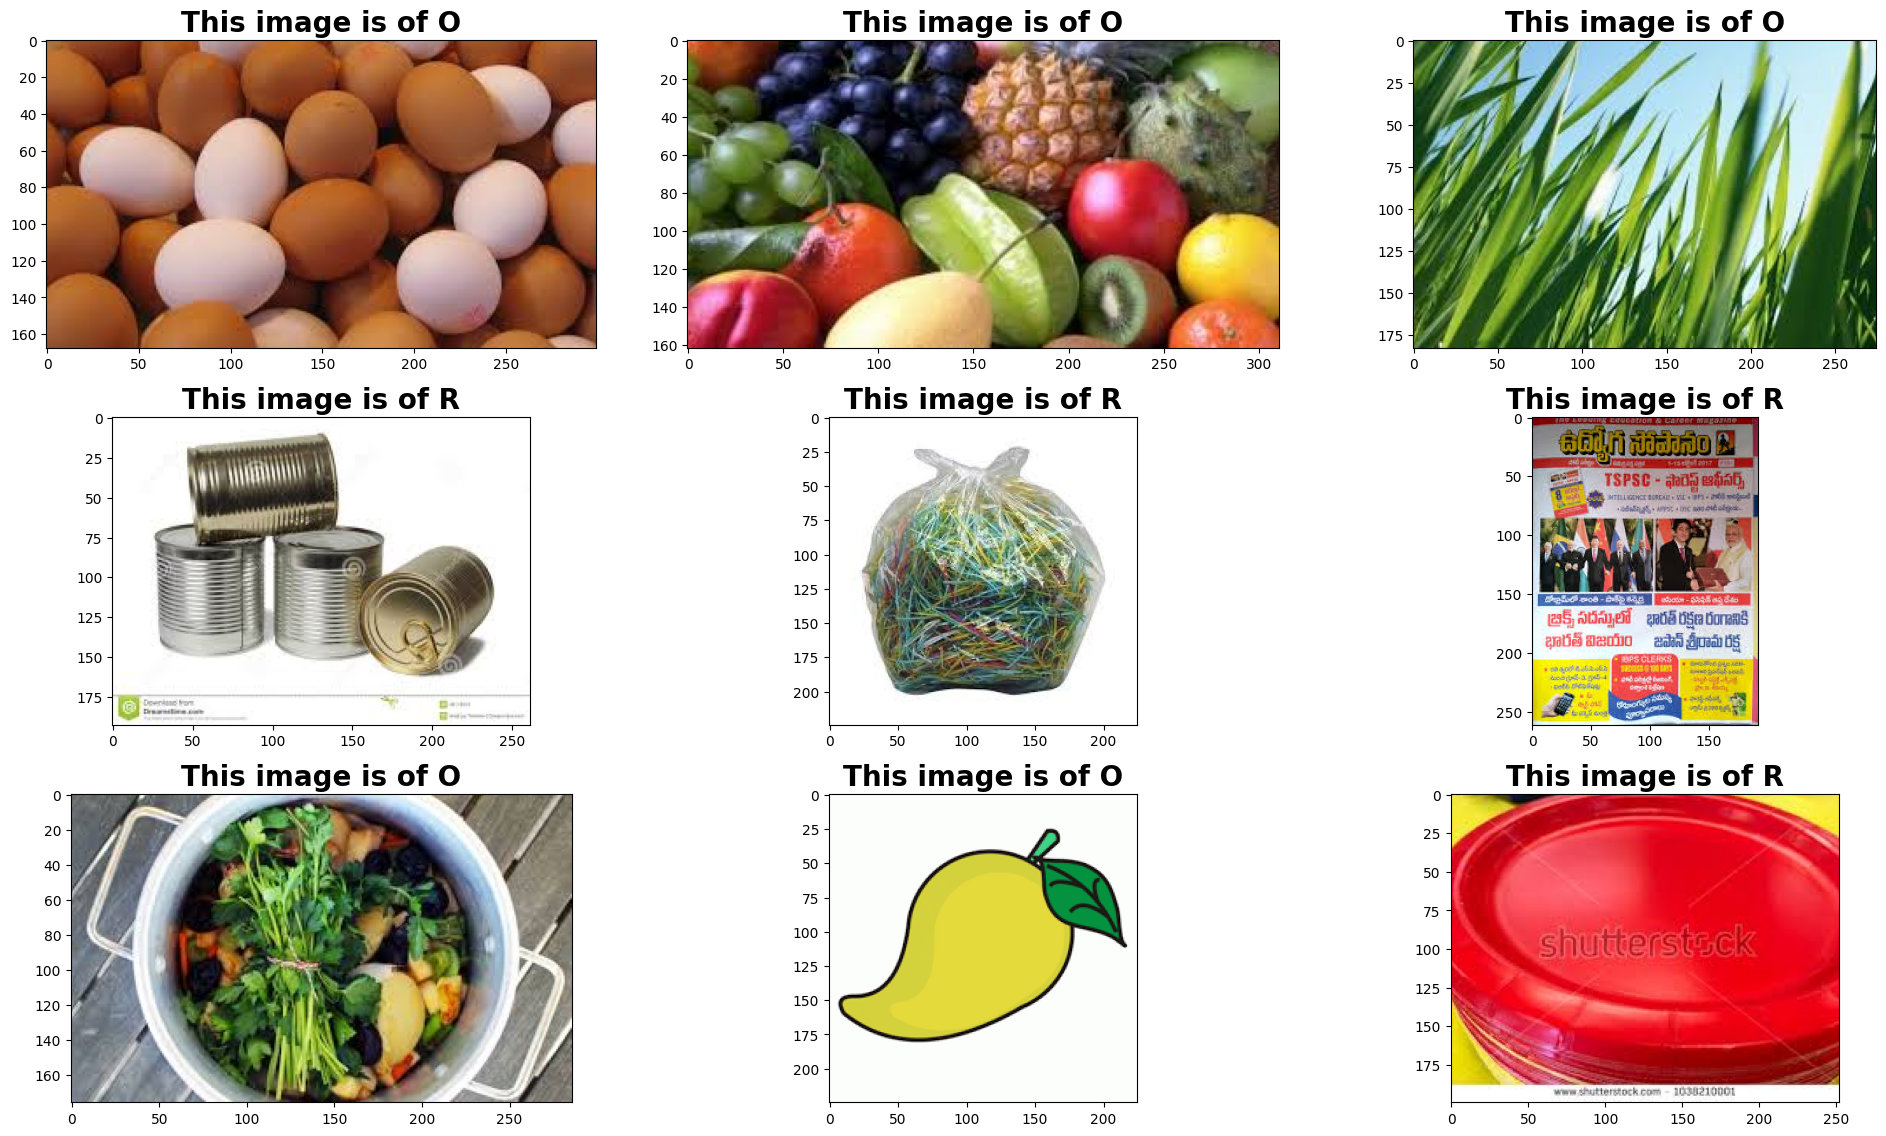

In [37]:
# Part 4: Data Exploration and Visualization
from collections import Counter

x_data = []
y_data = []

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

data = pd.DataFrame({'image': x_data, 'label': y_data})

label_counts = Counter(y_data)
colors = ['#a0d157', '#c48bb8']
explode = [0.1, 0.1]  # Adjust these values based on the dataset

plt.pie(label_counts.values(), startangle=90, explode=explode, autopct='%0.2f%%',
        labels=label_counts.keys(), colors=colors, radius=2)
plt.show()

plt.figure(figsize=(20, 15))
for i in range(9):
    plt.subplot(4, 3, (i % 12) + 1)
    index = np.random.randint(len(data))
    plt.title('This image is of {0}'.format(data.label[index]), fontdict={'size': 20, 'weight': 'bold'})
    plt.imshow(data.image[index])
    plt.tight_layout()

className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ", numberOfClass)


In [38]:
# Part 5: CNN Model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass))  # output
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


In [39]:
# Part 6: Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=64,  # Adjust based on available GPU memory
    color_mode="rgb",
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=64,
    color_mode="rgb",
    class_mode="categorical"
)


Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [40]:
from keras.applications import EfficientNetB0
from keras.callbacks import LearningRateScheduler

In [41]:
# Part 7: Model Training with Learning Rate Scheduler
def lr_schedule(epoch):
    return 0.001 * (0.1 ** int(epoch / 10))

lr_scheduler = LearningRateScheduler(lr_schedule)

hist = model.fit_generator(
    generator=train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[lr_scheduler]
)


Epoch 1/20
353/353 [==============================] - 309s 848ms/step - loss: 0.4718 - accuracy: 0.7985 - val_loss: 0.3700 - val_accuracy: 0.8098 - lr: 0.0010
Epoch 2/20
353/353 [==============================] - 296s 840ms/step - loss: 0.4023 - accuracy: 0.8347 - val_loss: 0.3380 - val_accuracy: 0.8774 - lr: 0.0010
Epoch 3/20
353/353 [==============================] - 297s 841ms/step - loss: 0.3880 - accuracy: 0.8417 - val_loss: 0.3755 - val_accuracy: 0.8707 - lr: 0.0010
Epoch 4/20
353/353 [==============================] - 295s 835ms/step - loss: 0.3675 - accuracy: 0.8495 - val_loss: 0.2702 - val_accuracy: 0.8993 - lr: 0.0010
Epoch 5/20
353/353 [==============================] - 290s 821ms/step - loss: 0.3538 - accuracy: 0.8584 - val_loss: 0.2973 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 6/20
353/353 [==============================] - 296s 838ms/step - loss: 0.3431 - accuracy: 0.8650 - val_loss: 0.2284 - val_accuracy: 0.9172 - lr: 0.0010
Epoch 7/20
353/353 [==========================

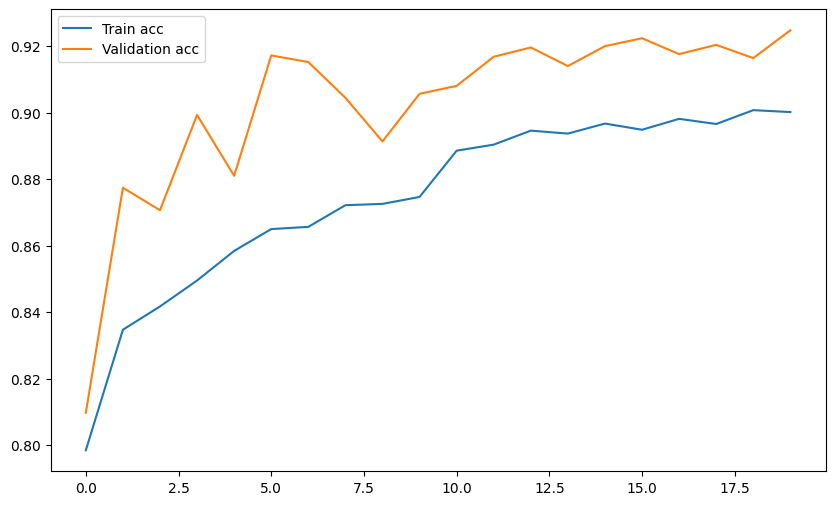

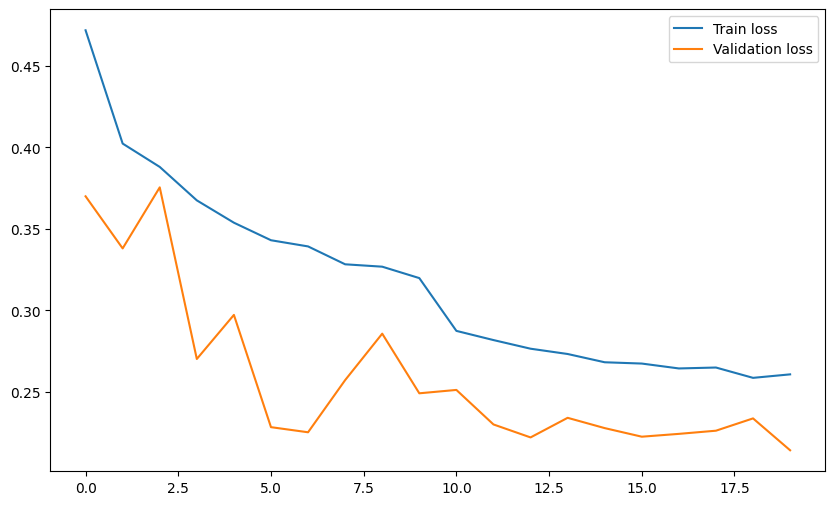

In [42]:
# Part 8: Model Evaluation
plt.figure(figsize=[10, 6])
plt.plot(hist.history["accuracy"], label="Train acc")
plt.plot(hist.history["val_accuracy"], label="Validation acc")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(hist.history['loss'], label="Train loss")
plt.plot(hist.history['val_loss'], label="Validation loss")
plt.legend()
plt.show()


2/2 [==============================] - 1s 13ms/step


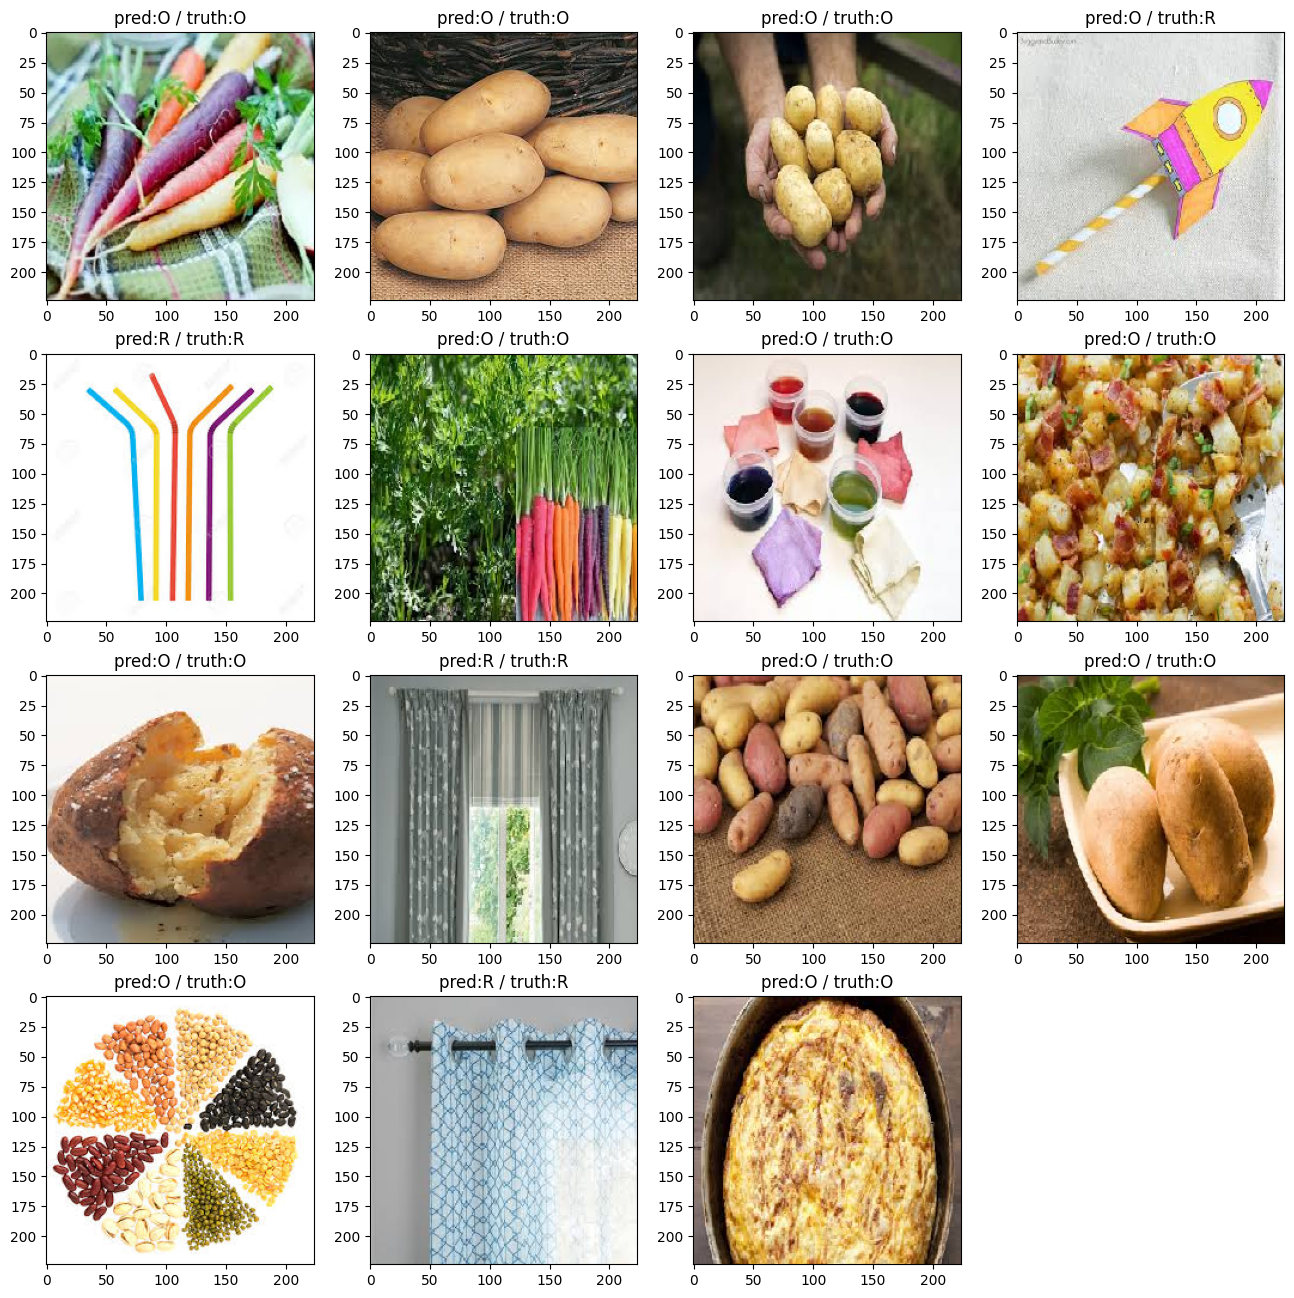

In [43]:
# Part 9: Model Prediction on Unseen Data
test_x, test_y = test_generator.__getitem__(1)
labels = (test_generator.class_indices)
labels = dict((v, k) for k, v in labels.items())
preds = model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(15):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])


In [45]:
import tensorflow as tf


In [46]:
# Save the model in TensorFlow Lite format
model.save('/content/waste_classifier_model.h5')

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('/content/waste_classifier_model.tflite', 'wb') as f:
    f.write(tflite_model)
